In [1]:
# To run this example, move this file to the main directory of this repository
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import cvxpy as cp
import json
import time
from agents.rbc import RBC
from copy import deepcopy


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Select the climate zone and load environment
climate_zone = 5
sim_period = (0, 8760*4-1)
params = {'data_path':Path("data/Climate_Zone_"+str(climate_zone)), 
        'building_attributes':'building_attributes.json', 
        'weather_file':'weather_data.csv', 
        'solar_profile':'solar_generation_1kW.csv', 
        'carbon_intensity':'carbon_intensity.csv',
        'building_ids':["Building_"+str(i) for i in [1,2,3,4,5,6,7,8,9]],
        'buildings_states_actions':'buildings_state_action_space.json', 
        'simulation_period': sim_period, 
        'cost_function': ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','carbon_emissions'], 
        'central_agent': False,
        'save_memory': False }

env = CityLearn(**params)

observations_spaces, actions_spaces = env.get_state_action_spaces()

In [3]:
### load weather data for calculation of COP
with open(env.data_path / env.weather_file) as csv_file:
    weather_data = pd.read_csv(csv_file)
weather_data = weather_data['Outdoor Drybulb Temperature [C]']

## Load Data

In [4]:
def get_current_data(env, t):
    """ Returns data:dic for each building from `env` for `t` timestep """
    
    ### FB - Full batch. Trim output X[:time-step]
    ### CT - current timestep only. X = full_data[time-step], no access to full_data
    ### DP - dynamic update. time-step k = [... k], time-step k+n = [... k + n].
    ### P - constant value across all time steps. changes per building only.
    
    _max_load = 2 * 168 # 2-week max load
    _num_buildings = len(actions_spaces) # total number of buildings in env.
    
    observation_data = {}
    
    p_ele = [2 if 10 <= t % 24 <= 20 else 0.2 for i in range(1, _num_buildings+1)] # FB -- virtual electricity price.
    E_grid_past = [env.net_electric_consumption[-1] for i in range(1, _num_buildings+1)] #FB -- replace w/ per building cost
    ramping_cost_coeff = [0.1 for i in range(_num_buildings)] #P  -- initialized to 0.1, learned through diff.
    
    # Loads
    E_ns = [env.buildings['Building_'+str(i)].get_non_shiftable_load() for i in range(1, _num_buildings+1)] #CT
    H_bd = [env.buildings['Building_'+str(i)].dhw_heating_device_to_building[-1] for i in range(1, _num_buildings+1)] #DP
    C_bd = [env.buildings['Building_'+str(i)].cooling_device_to_building[-1] for i in range(1, _num_buildings+1)] #DP
    H_max = 1.2 * np.max([env.buildings['Building_'+str(i)].dhw_heating_device_to_building[-_max_load :] for i in range(1, _num_buildings+1)], axis=1) #DP
    C_max = 1.2 * np.max([env.buildings['Building_'+str(i)].cooling_device_to_building[-_max_load :] for i in range(1, _num_buildings+1)], axis=1) #DP
    
    # PV generations
    E_pv = [env.buildings['Building_'+str(i)].get_solar_power() for i in range(1, _num_buildings+1)] #CT
    
    # Heat Pump
    eta_hp = [0.22]*_num_buildings #P
    t_C_hp = [8]*_num_buildings #P target cooling temperature (universal constant)
    
    #### CityLearn.py def. doesn't make too much sense. !!!! NOTE: THIS IS NOT UDPATED to CITYLEARN !!!!
    COP_C = [eta_hp[i] * float(t_C_hp[i] + 273.15) / float(273.15 + weather_data[t] - t_C_hp[i])  for i in range(_num_buildings)] #DP
    
    E_hpC_max = [None]*_num_buildings
    ratio = 12.2
    for i in range(1, _num_buildings + 1):
        try:
            E_hpC_max[i - 1] = np.max(env.buildings['Building_'+str(i)].sim_results['non_shiftable_load'][:t]) * ratio
            max_soc = np.max(env.buildings['Building_'+str(i)].cooling_storage.soc[:t])
            E_hpC_max[i - 1] = max(E_hpC_max[i - 1], max_soc)

        except ValueError:
            pass
    
    
    # Electric Heater
    eta_ehH = [0.9]*_num_buildings #P
    #replaced capacity (not avaiable in electric heater) w/ nominal_power
    E_ehH_max = [H_max[i] / eta_ehH[i] for i in range(_num_buildings)] #P
    
    # Battery
    C_f_bat = [0.00001 for i in range(_num_buildings)] #P
    C_p_bat = [100]*_num_buildings #P (range: [20, 200])
    eta_bat = [1]*_num_buildings #P
    #current hour soc. normalized
    c_bat_end = [None]*_num_buildings
    for i in range(1, 10):
        building = env.buildings['Building_' + str(i)].electrical_storage
        c_bat_end[i-1] = building.soc[-1] / building.capacity
    
    # Heat (Energy->dhw) Storage
    C_f_Hsto = [0.008]*_num_buildings #P
    C_p_Hsto = [3]*_num_buildings #P
    eta_Hsto = [1]*_num_buildings #P
    #current hour soc. normalized
    c_Hsto_end = [None]*_num_buildings
    for i in range(1, 10):
        building = env.buildings['Building_' + str(i)].dhw_storage
        c_Hsto_end[i-1] = building.soc[-1] / building.capacity 
        
    # Cooling (Energy->cooling) Storage
    C_f_Csto = [0.006]*_num_buildings #P
    C_p_Csto = [2]*_num_buildings #P
    eta_Csto = [1]*_num_buildings #P
    c_Csto_end = [env.buildings['Building_'+str(i)].cooling_storage.soc[-1] for i in range(1, _num_buildings + 1)] #DP (constant for now, pre differentiation. see doc for learnable params (green))
    #current hour soc. normalized
    c_Csto_end = [None]*_num_buildings
    for i in range(1, 10):
        building = env.buildings['Building_' + str(i)].cooling_storage
        c_Csto_end[i-1] = building.soc[-1] / building.capacity
    
    
    # fill data
    observation_data['p_ele'] = p_ele
    observation_data['ramping_cost_coeff'] = ramping_cost_coeff
    observation_data['E_grid_past'] = E_grid_past
    
    observation_data['E_ns'] = E_ns
    observation_data['H_bd'] = H_bd
    observation_data['C_bd'] = C_bd
    observation_data['H_max'] = H_max
    observation_data['C_max'] = C_max
    
    observation_data['E_pv'] = E_pv
    
    observation_data['E_hpC_max'] = E_hpC_max
    observation_data['eta_hp'] = eta_hp
    observation_data['t_C_hp'] = t_C_hp
    observation_data['COP_C'] = COP_C
    
    observation_data['eta_ehH'] = eta_ehH
    observation_data['E_ehH_max'] = E_ehH_max
    
    observation_data['C_f_bat'] = C_f_bat
    observation_data['C_p_bat'] = C_p_bat
    observation_data['eta_bat'] = eta_bat
    observation_data['c_bat_end'] = c_bat_end
    
    observation_data['C_f_Hsto'] = C_f_Hsto
    observation_data['C_p_Hsto'] = C_p_Hsto
    observation_data['eta_Hsto'] = eta_Hsto
    observation_data['c_Hsto_end'] = c_Hsto_end
    
    observation_data['C_f_Csto'] = C_f_Csto
    observation_data['C_p_Csto'] = C_p_Csto
    observation_data['eta_Csto'] = eta_Csto
    observation_data['c_Csto_end'] = c_Csto_end
    
    return observation_data

In [5]:
def parse_data(data:dict, current_data:dict):
    """ Parses `current_data` for optimization and loads into `data` """
    assert len(current_data) == 27, "Invalid number of parameters. Can't run basic (root) agent optimization"
    
    for key, value in current_data.items():
        if key not in data:
            data[key] = []
        data[key].append(value)
        
    for key, value in current_data.items():
        if np.array(data[key]).shape == (1, 9):#removes duplicates
            data[key] = [value]
    return data

In [6]:
def get_dimensions(data:dict):
    """ Gets shape of each param """
    for key in data.keys():
        print(data[key].shape)

In [7]:
def get_building(data:dict, building_id:int):
    """ Loads data (dict) from a particular building. 1-based indexing for building """
    assert building_id > 0, "building_id is 1-based indexing."
    building_data = {}
    for key in data.keys():
        building_data[key] = np.array(data[key])[:, building_id - 1]
    return building_data

## Optimization

In [8]:
def convert_to_numpy(params:dict):
    """ Converts dic[key] to nd.array """
    for key in params:
        if key == 'c_bat_end' or key == 'c_Csto_end' or key == 'c_Hsto_end':
            params[key] = np.array([params[key][0], params[key][-1]])
            params[key][1] = 0.1
        else:
            params[key] = np.array(params[key])

In [9]:
def create_random_data(data:dict):
    """ Creates random data drawn from Gaussian. """
    for key in data:
        data[key] = np.clip(np.random.random(size=data[key].shape), 0, 1)
    return data

In [10]:
def get_actions(data:dict, t, debug=False, apply_seed=False, lookahead=False):
    """ Runs Optim for all 9 buildings per hour. `lookahead` once set to `True` computes day-ahead dispatch """
    convert_to_numpy(data)
    data = create_random_data(deepcopy(data)) if apply_seed else data
    if debug:
        return [Optim(t, data, i, actions_spaces[i].shape[0]) for i in range(9)]

    return [Optim(t, data, i, actions_spaces[i].shape[0]).solve(debug, lookahead) for i in range(9)]

In [11]:
class Optim:
    """ Define Differential Optimization framework for CL. """
    def __init__(self, t:int, parameters:dict, building_id:int, num_actions:int):
        """ 
        @Param:
        - `parameters` : data (dict) from r <= t <= T following `get_current_data` format.
        - `T` : 24 hours (constant)
        - `t` : hour to solve optimization for.
        - `building_id`: building index number (0-based)
        - `num_actions`: Number of actions for building 
            NOTE: right now, this is an integer, but will be checked programmatically.
        Solves per building as specified by `building_id`. Note: 0 based.
        """
        T = 24
        window = T - t
        self.constraints = []
        self.costs = []
        self.t = t
        self.num_actions = num_actions
        
        # -- define action space -- #
        bounds_high, bounds_low = np.vstack([actions_spaces[building_id].high, actions_spaces[building_id].low])
        #parse to dictionary --- temp... need to check w/ state-action-dictionary.json !!! @Zhaiyao !!!
        if len(bounds_high) == 2:
            bounds_high = {'action_H' : bounds_high[0], 'action_C' : None, 'action_bat' : bounds_high[1]}
            bounds_low = {'action_H' : bounds_low[0], 'action_C' : None, 'action_bat' : bounds_low[1]}
        else:
            bounds_high = {'action_H' : bounds_high[0], 'action_C' : bounds_high[1], 'action_bat' : bounds_high[2]}
            bounds_low = {'action_H' : bounds_low[0], 'action_C' : bounds_low[1], 'action_bat' : bounds_low[2]}
            
        # -- define action space -- #
        
        #define parameters and variables
        
        ### --- Parameters ---
        p_ele = cp.Parameter(name='p_ele', shape=(window), value=parameters['p_ele'][t:, building_id])
        E_grid_prevhour = cp.Parameter(name='E_grid_prevhour', 
                                       value=parameters['E_grid_past'][min(t-1, 0), building_id])
        
        E_grid_pkhist = cp.Parameter(name='E_grid_pkhist', 
                                    value=parameters['E_grid_past'][:(t+1), building_id].max())

        # max-min normalization of ramping_cost to downplay E_grid_sell weight.
        ramping_cost_coeff = cp.Parameter(name='ramping_cost_coeff', 
                                          value=parameters['ramping_cost_coeff'][t, building_id])
        
        # Loads
        E_ns = cp.Parameter(name='E_ns', shape=(window), value=parameters['E_ns'][t:, building_id])
        H_bd = cp.Parameter(name='H_bd', shape=(window), value=parameters['H_bd'][t:, building_id])
        C_bd = cp.Parameter(name='C_bd', shape=(window), value=parameters['C_bd'][t:, building_id])
        
        # PV generations
        E_pv = cp.Parameter(name='E_pv', shape=(window), value=parameters['E_pv'][t:, building_id])

        # Heat Pump
        COP_C = cp.Parameter(name='COP_C', shape=(window), value=parameters['COP_C'][t:, building_id])
        E_hpC_max = cp.Parameter(name='E_hpC_max', value=parameters['E_hpC_max'][t, building_id])

        # Electric Heater
        eta_ehH = cp.Parameter(name='eta_ehH', value=parameters['eta_ehH'][t, building_id])
        E_ehH_max = cp.Parameter(name='E_ehH_max', value=parameters['E_ehH_max'][t, building_id])

        # Battery
        C_f_bat = cp.Parameter(name='C_f_bat', value=parameters['C_f_bat'][t, building_id])
        C_p_bat = parameters['C_p_bat'][t, building_id] #cp.Parameter(name='C_p_bat', value=parameters['C_p_bat'][t, building_id])
        eta_bat = cp.Parameter(name='eta_bat', value=parameters['eta_bat'][t, building_id])
        soc_bat_init = cp.Parameter(name='soc_bat_init', value=parameters['c_bat_end'][0, building_id])
        soc_bat_norm_end = cp.Parameter(name='soc_bat_norm_end', value=parameters['c_bat_end'][1, building_id])
        
        # Heat (Energy->dhw) Storage
        C_f_Hsto = cp.Parameter(name='C_f_Hsto', value=parameters['C_f_Hsto'][t, building_id]) #make constant.
        C_p_Hsto = cp.Parameter(name='C_p_Hsto', value=parameters['C_p_Hsto'][t, building_id])
        eta_Hsto = cp.Parameter(name='eta_Hsto', value=parameters['eta_Hsto'][t, building_id])
        soc_Hsto_init = cp.Parameter(name='soc_Hsto_init', value=parameters['c_Hsto_end'][0, building_id])

        # Cooling (Energy->cooling) Storage
        C_f_Csto = cp.Parameter(name='C_f_Csto', value=parameters['C_f_Csto'][t, building_id])
        C_p_Csto = cp.Parameter(name='C_p_Csto', value=parameters['C_p_Csto'][t, building_id])
        eta_Csto = cp.Parameter(name='eta_Csto', value=parameters['eta_Csto'][t, building_id])
        soc_Csto_init = cp.Parameter(name='soc_Csto_init', value=parameters['c_Csto_end'][0, building_id])

        ### --- Variables ---
        
        #relaxation variables - prevents numerical failures when solving optimization
        E_bal_relax = cp.Variable(name='E_bal_relax', shape=(window)) #electricity balance relaxation
        H_bal_relax = cp.Variable(name='H_bal_relax', shape=(window)) #heating balance relaxation
        C_bal_relax = cp.Variable(name='C_bal_relax', shape=(window)) #cooling balance relaxation
        
        E_grid = cp.Variable(name='E_grid', shape=(window)) #net electricity grid
        E_grid_sell = cp.Variable(name='E_grid_sell', shape=(window)) #net electricity grid
        
        E_hpC = cp.Variable(name='E_hpC', shape=(window)) #heat pump
        E_ehH = cp.Variable(name='E_ehH', shape=(window)) #electric heater
        
        SOC_bat = cp.Variable(name='SOC_bat', shape=(window)) #electric battery
        SOC_Brelax = cp.Variable(name='SOH_Brelax', shape=(window)) #electrical battery relaxation (prevents numerical infeasibilities)
        action_bat = cp.Variable(name='action_bat', shape=(window)) #electric battery
    
        SOC_H = cp.Variable(name='SOC_H', shape=(window)) #heat storage
        SOC_Hrelax = cp.Variable(name='SOH_Crelax', shape=(window)) #heat storage relaxation (prevents numerical infeasibilities)
        action_H = cp.Variable(name='action_H', shape=(window)) #heat storage

        SOC_C = cp.Variable(name='SOC_C', shape=(window)) #cooling storage
        SOC_Crelax = cp.Variable(name='SOC_Crelax', shape=(window)) #cooling storage relaxation (prevents numerical infeasibilities)
        action_C = cp.Variable(name='action_C', shape=(window)) #cooling storage
        
        
        ### objective function
        ramping_cost = cp.abs(E_grid[0] - E_grid_prevhour) + cp.sum(cp.abs(E_grid[1:] - E_grid[:-1])) # E_grid_t+1 - E_grid_t
        peak_net_electricity_cost = cp.max(cp.atoms.affine.hstack.hstack([*E_grid, E_grid_pkhist])) #max(E_grid, E_gridpkhist)
        electricity_cost = cp.sum(p_ele * E_grid)
        
        ### relaxation costs - L1 norm
        # balance eq.
        E_bal_relax_cost = cp.sum(cp.abs( E_bal_relax ))
        H_bal_relax_cost = cp.sum(cp.abs( H_bal_relax ))
        C_bal_relax_cost = cp.sum(cp.abs( C_bal_relax ))
        # soc eq.
        SOC_Brelax_cost = cp.sum(cp.abs( SOC_Brelax ))
        SOC_Crelax_cost = cp.sum(cp.abs( SOC_Crelax ))
        SOC_Hrelax_cost = cp.sum(cp.abs( SOC_Hrelax ))
        
        self.costs.append(ramping_cost_coeff.value * ramping_cost + peak_net_electricity_cost + electricity_cost + 
                          E_bal_relax_cost + H_bal_relax_cost + C_bal_relax_cost 
                          + SOC_Brelax_cost + SOC_Crelax_cost + SOC_Hrelax_cost)
        
        
        ### constraints
        self.constraints.append( E_grid >= 0 )
        self.constraints.append( E_grid_sell <= 0 )
        
        #energy balance constraints
        self.constraints.append( E_pv + E_grid + E_grid_sell + E_bal_relax == E_ns + E_hpC + E_ehH + action_bat * C_p_bat) #electricity balance
        self.constraints.append( E_ehH * eta_ehH + H_bal_relax == action_H * C_p_Hsto + H_bd ) #heat balance
        
        #!!!!! Problem Child !!!!!
        self.constraints.append( E_hpC * COP_C + C_bal_relax == action_C * C_p_Csto + C_bd ) #cooling balance
        #!!!!! Problem Child !!!!!
        
        
        #heat pump constraints
        self.constraints.append( E_hpC <= E_hpC_max ) #maximum cooling
        self.constraints.append( E_hpC >= 0 ) #constraint minimum cooling to positive
        #electric heater constraints
        self.constraints.append( E_ehH >= 0 ) #constraint to PD
        self.constraints.append( E_ehH <= E_ehH_max ) #maximum limit
        
        #electric battery constraints
        
        self.constraints.append( SOC_bat[0] == (1 - C_f_bat)*soc_bat_init + action_bat[0]*eta_bat + SOC_Crelax[0] ) #initial SOC
        #soc updates
        for i in range(1, window): #1 = t + 1
            self.constraints.append( SOC_bat[i] == (1 - C_f_bat)*SOC_bat[i - 1] + action_bat[i]*eta_bat + SOC_Crelax[i])
        self.constraints.append( SOC_bat[-1] == soc_bat_norm_end ) #soc terminal condition
        self.constraints.append(SOC_bat >= 0) #battery SOC bounds
        self.constraints.append(SOC_bat <= 1) #battery SOC bounds

        #Heat Storage constraints
        self.constraints.append( SOC_H[0] == (1 - C_f_Hsto) * soc_Hsto_init + action_H[0]*eta_Hsto + SOC_Hrelax[0]) #initial SOC
        #soc updates
        for i in range(1, window):
            self.constraints.append( SOC_H[i] == (1 - C_f_Hsto)*SOC_H[i - 1] + action_H[i]*eta_Hsto + SOC_Hrelax[i])
        self.constraints.append(SOC_H >= 0) #battery SOC bounds
        self.constraints.append(SOC_H <= 1) #battery SOC bounds
        
        #Cooling Storage constraints
        self.constraints.append( SOC_C[0] == (1 - C_f_Csto) * soc_Csto_init + action_C[0]*eta_Csto + SOC_Crelax[0]) #initial SOC
        #soc updates
        for i in range(1, window):
            self.constraints.append( SOC_C[i] == (1 - C_f_Csto)*SOC_C[i - 1] + action_C[i]*eta_Csto + SOC_Crelax[i])
        self.constraints.append(SOC_C >= 0) #battery SOC bounds
        self.constraints.append(SOC_C <= 1) #battery SOC bounds
        
        
        #### action constraints (limit to action-space)
        #format: AS[building_id][0/1 (high/low)][heat, cool, battery]
        
        heat_high, cool_high, battery_high = bounds_high
        heat_low, cool_low, battery_low = bounds_low
        
        assert len(bounds_high) == 3, 'Invalid number of bounds for actions - see dict defined in `Optim`'
        
        for high, low in zip(bounds_high.items(), bounds_low.items()):
            key, h, l = [*high, low[1]]
            if not (h and l): #throw DeMorgan's in!!!
                continue
                
            #heating action
            if key == 'action_H':
                self.constraints.append(action_H <= h)
                self.constraints.append(action_H >= l)
            #cooling action
            elif key == 'action_C':
                self.constraints.append(action_C <= h)
                self.constraints.append(action_C >= l)
            #Battery action
            elif key == 'action_bat':
                self.constraints.append(action_bat <= h)
                self.constraints.append(action_bat >= l)

    def solve(self, debug=False, dispatch=False):
        # Form objective.
        obj = cp.Minimize(*self.costs)
        # Form and solve problem.
        prob = cp.Problem(obj, self.constraints)
        status = prob.solve(verbose=debug)  # Returns the optimal value.

        if float('-inf') < status < float('inf'):
            pass
        else:
            return "Unbounded Solution"
            
        actions = {}
        for var in prob.variables():
            if dispatch:
                actions[var.name()] = np.array(var.value) #no need to clip... automatically restricts range
            else:
                actions[var.name()] = var.value[0] #no need to clip... automatically restricts range
        
        #Temporary... needs fixing!
        ## compute dispatch cost
        params = {x.name() : x.value for x in prob.parameters()}

        if dispatch:
            ramping_cost = np.sum(np.abs(actions['E_grid'][1: ] - actions['E_grid'][:-1]))
            net_peak_electricity_cost = np.max(actions['E_grid'])
            virtual_electricity_cost = np.sum(params['p_ele'] * actions['E_grid'])
            dispatch_cost = ramping_cost + net_peak_electricity_cost + virtual_electricity_cost
            
        if self.num_actions == 2:
            return [actions['action_H'], actions['action_bat']], dispatch_cost if dispatch else None
        return [actions['action_H'], actions['action_C'], actions['action_bat']], dispatch_cost if dispatch else None

In [12]:
# #optimization debug -> !!! PROBLEM !!!
# debug = get_actions(data_est, 11, debug=False) # for each building: [actions (size 2/3)], cost (if available)
# debug

## RBC for Data Collection 

In [13]:
def get_idx_hour():
    # Finding which state 
    with open('buildings_state_action_space.json') as file:
        actions_ = json.load(file)

    indx_hour = -1
    for obs_name, selected in list(actions_.values())[0]['states'].items():
        indx_hour += 1
        if obs_name=='hour':
            break
        assert indx_hour < len(list(actions_.values())[0]['states'].items()) - 1, "Please, select hour as a state for Building_1 to run the RBC"
    return indx_hour

In [14]:
def estimate_data(surrogate_env:CityLearn, agent:RBC, state, data, idx_hour:int, t_start:int, init_updates:dict):
    """ Returns data for hours `t_start` - 24 using `surrogate_env` running RBC `agent` """
    for i in range(t_start%24, 24):
        hour_state = np.array([[state[0][idx_hour]]])
        action = agents.select_action(hour_state) #using RBC to select next action given current sate
        next_state, rewards, done, _ = surrogate_env.step(action)
        state = next_state
        
        data = parse_data(data, get_current_data(surrogate_env, t_start + i))
        
    return init_values(data, init_updates)[0] if t_start == 0 else data #only load previous values at start of day

In [15]:
def init_values(data:dict, update_values:dict=None):
    """ Loads eod values for SOC and E_grid_past before(after) wiping data cache """
    if update_values:
        #assign previous day's end socs.
        data['c_bat_end'][0] =  update_values['c_bat_end']
        data['c_Hsto_end'][0] = update_values['c_Hsto_end']
        data['c_Csto_end'][0] = update_values['c_Csto_end']
            
        #assign previous day's end E_grid.
        data['E_grid_past'][0] = update_values['E_grid_past']
    else:
        update_values = {'c_bat_end' : data['c_bat_end'][-1], 'c_Hsto_end' : data['c_Hsto_end'][-1], 
                         'c_Csto_end' : data['c_Csto_end'][-1], 'E_grid_past' : data['E_grid_past'][-1]}
        
    return data, update_values

In [16]:
#### accumulate
data = {}
actions_arr = [] #plot actions
E_ns = []
#### accumulate


state = env.reset() #states/building
done = False
t_idx = 0
rbc_threshold = 336 #run RBC for 2 weeks

total_rewards = [] #reward for each building

agents = RBC(actions_spaces)
indx_hour = get_idx_hour()

start = time.time()

look_ahead_cost = []
#run agent
while not done and t_idx < rbc_threshold + 24*30:

    hour_state = np.array([[state[0][indx_hour]]])

    if t_idx%24 == 0 and t_idx > 0: #reset values every day
        
        _, init_updates = init_values(data) #update 0th hour values 
        data = {}
            
    if t_idx%1460 < rbc_threshold:
        action = agents.select_action(hour_state)
        next_state, rewards, done, _ = env.step(action)
    else:
        #day ahead dispatch.
        ### at first hour, collects the data from t = 1 to t = 24 using RBC. 
        ### solves optimization for all hours, and runs corresponding actions for the next 23 hours
        if not data: #first hour
            data_est = estimate_data(deepcopy(env), agents, state, deepcopy(data), indx_hour, t_idx, init_updates)
            optim_results = get_actions(data_est, t_idx % 24, lookahead=True) #day-ahead plan
            action_planned_day, cost_dispatch = zip(*optim_results)
            look_ahead_cost.append(cost_dispatch) # per day estimation cost after solving for hour 1 for hours 1-24
        #action = get_actions(data_est, t_idx % 24) #runs optimization per hour.
        assert len(action_planned_day[0][0]) == 24, 'Invalid number of observations for Optimization actions'
        
        actions = [np.array(action_planned_day[idx])[:, t_idx % 24] for idx in range(len(actions_spaces))]
        
        #min_val = min([_.min() for _ in actions])
        #max_val = max([_.max() for _ in actions])
        #assert min_val >= - 1 and max_val <= 1
        
        next_state, rewards, done, _ = env.step(actions)
        actions_arr.append(actions)
    
    state = next_state
    E_ns.append([x[26] for x in state])
    
    
    data = parse_data(data, get_current_data(env, t_idx))
    total_rewards.append(rewards)
    
    t_idx += 1
    
    print(f"\rTime step: {t_idx}", end='')
    
end = time.time()
print(f"\nTotal time = {end - start}")
E_ns = np.array(E_ns).T #set per building

Time step: 1056
Total time = 197.5972490310669


In [17]:
# print(f"Violated constraint : {(t_idx - rbc_threshold)%24}")

In [18]:
# vals = np.transpose(look_ahead_cost, [1,2,0])
# # plt.figure(figsize=(10, 7))

# bid = 8
# x = E_ns[bid][rbc_threshold:]

# true = np.mean(x.reshape(-1, 24), axis=1)
# true /= np.linalg.norm(true)

# pred = np.mean(vals[bid].flatten().reshape(-1, 24), axis=1)
# pred /= np.linalg.norm(pred)
                
# plt.plot(true, label='True consumption') #plots per month
# plt.plot(pred, label='Predicted consumption') #plots per month

# plt.grid()
# plt.legend()
# plt.title(f"Building {bid + 1}")
# plt.xlabel("Day")
# plt.ylabel("E_grid")
# plt.show()

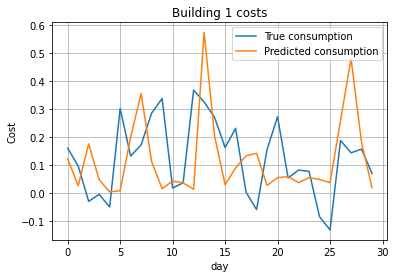

MSE: 0.8354261113218702


In [51]:
### Shouldn't have to normalize. But cost is in the order of 1e-9. that's why. 
### See test documentation for more details

bid = 0
x = E_ns[bid][rbc_threshold:]
true = np.mean(x.reshape(-1, 24), axis=1)
true /= np.linalg.norm(true)

cost_ = np.array(look_ahead_cost).T[bid].astype(np.float)
pred = cost_ / np.linalg.norm(cost_)

plt.plot(true, label='True consumption') #plots per month
plt.plot(pred, label='Predicted consumption') #plots per month

plt.legend()
plt.grid()

plt.title(f"Building {bid + 1} costs")
plt.xlabel("day")
plt.ylabel("Cost")

plt.show()

print(f"MSE: {np.sum(np.square(np.abs(pred - true)))}")

In [20]:
bd_actions = []
for actions in np.array(actions_arr):
    bd_actions.append(actions)

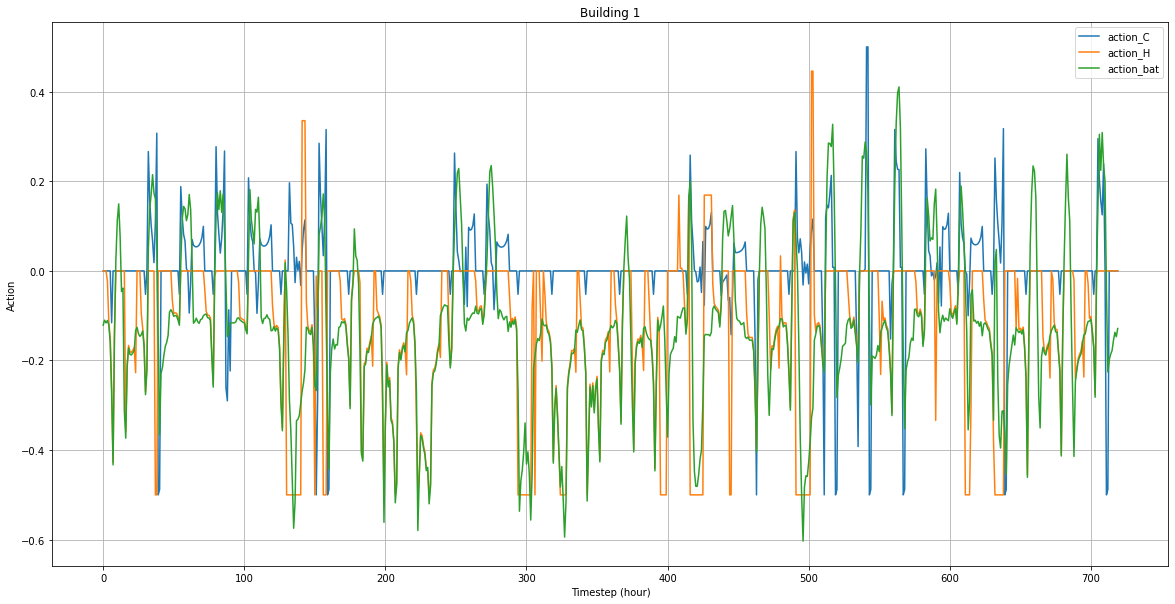

In [21]:
plt.figure(figsize=(20,10))

####
bid = 0
####

x = np.array([*np.array(bd_actions).T[bid]]).T

list_actions = ['action_C', 'action_H', 'action_bat']

if len(x) == 2:
    list_actions = ['action_C', 'action_bat']
    
    
for i, actions in enumerate(x):
    plt.plot(actions, label=list_actions[i])
plt.legend()
plt.grid()
# plt.ylim([-1, 1])
plt.title(f"Building {bid + 1}")
plt.xlabel("Timestep (hour)")
plt.ylabel("Action")
plt.show()

In [22]:
#optimization debug -> !!! PROBLEM !!!
debug = get_actions(data_est, (t_idx - rbc_threshold) % 24, debug=False, apply_seed=False)
for i in range(len(debug)):
    print(i, debug[i])

0 ([2.9730358891501468e-09, -2.4148037131048515e-07, -0.1407000001019795], None)
1 ([8.924185351338473e-10, -1.2392501195898149e-08, -0.019200000030594137], None)
2 ([2.7716172533045277e-11, -0.023600000020642546], None)
3 ([3.362155984799809e-11, -0.0061084490318302305], None)
4 ([-0.054877334515121466, -9.719619711204044e-07, -0.13183742220214587], None)
5 ([-0.15999999709119117, 0.3333328910518795, -0.06900000010363912], None)
6 ([-0.05487738364568243, 0.29586603859271365, -0.14217075390091455], None)
7 ([-0.054877255528963616, -1.000999613067962e-06, -0.05183742484511278], None)
8 ([-0.054877436044086805, -0.02000002445517107, -0.07650408546569093], None)


In [23]:
pd.DataFrame([data_est['c_Csto_end'][0], data_est['c_Hsto_end'][0], *data_est['c_bat_end']], index=[
    "c_Csto_start", "c_Hsto_start", "c_bat_start", "c_bat_end"
])

,0,1,2,3,4,5,6,7,8
c_Csto_start,0.717563,0.326641,0.069600,0.069859,0.692860,0.597330,0.616056,0.675815,0.666724
c_Hsto_start,0.055320,0.055320,0.000000,0.000000,0.055320,0.659967,0.055320,0.055320,0.055320
c_bat_start,0.050399,0.050047,0.050399,0.050399,0.049821,0.050399,0.050399,0.050328,0.050399
c_bat_end,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [24]:
t_test = (t_idx - rbc_threshold) % 24
print(f"Mess up: {t_test}")

bd_debug = []
row_ind = []
for key in data_est.keys():
    if len(data_est[key]) > 2:
        row_ind.append(key)
        bd_debug.append(data_est[key][t_test])
pd.DataFrame(bd_debug, index=row_ind)

Mess up: 0


,0,1,2,3,4,5,6,7,8
p_ele,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
ramping_cost_coeff,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
E_grid_past,156.717300,156.717300,156.717300,156.717300,156.717300,156.717300,156.717300,156.717300,156.717300
E_ns,14.070000,1.920000,2.360000,0.440000,7.900000,6.900000,14.000000,3.900000,7.300000
H_bd,0.000000,0.000000,0.000000,0.000000,4.920000,0.480000,0.360000,1.320000,0.480000
C_bd,0.000000,0.000000,0.000000,0.040000,0.000000,0.320000,0.260000,0.000000,0.040000
H_max,6.408000,19.728000,0.000000,0.000000,31.824000,31.248000,33.552000,33.840000,29.376000
C_max,131.196000,20.220000,59.772000,57.060000,52.968000,51.912000,48.744000,33.000000,35.040000
E_pv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E_hpC_max,865.102000,227.369995,414.679993,383.565002,305.000000,278.160000,323.300000,301.340000,357.460000


In [25]:
# basic_agent_cost = env.cost()

In [26]:
# # Plotting 5 days of winter operation of year 1
# plt.figure(figsize=(16,5))
# interval = range(0,24*5)
# plt.plot(env.net_electric_consumption_no_pv_no_storage[interval])
# plt.plot(env.net_electric_consumption_no_storage[interval])
# plt.plot(env.net_electric_consumption[interval], '--')
# plt.xlabel('time (hours)')
# plt.ylabel('kW')
# plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand with PV generation and using RBC for storage(kW)'])

In [27]:
# total_rewards = np.array(total_rewards).T
# plt.figure(figsize=(15, 10))
# for i in range(9):
#     plt.plot(total_rewards[i], label='Building_'+str(i))

# plt.xlabel('Hour')
# plt.ylabel('Reward')
# plt.legend()
# plt.show()
# print(total_rewards.sum(1)) #total reward per building